## Importações e funções

### Libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

### Surfaces

In [2]:
global surface_names, snames_hf, snames_hs, mes

surfaces_names = ['PERIMETER_TOP_PLENUM_WALL_NORTH','PERIMETER_TOP_PLENUM_WALL_EAST',
'PERIMETER_TOP_PLENUM_WALL_SOUTH','PERIMETER_TOP_PLENUM_WALL_WEST','BUILDING_ROOF',
'PERIMETER_MID_PLENUM_WALL_NORTH','PERIMETER_MID_PLENUM_WALL_EAST','PERIMETER_MID_PLENUM_WALL_SOUTH',
'PERIMETER_MID_PLENUM_WALL_WEST','PERIMETER_BOT_PLENUM_WALL_NORTH','PERIMETER_BOT_PLENUM_WALL_EAST',
'PERIMETER_BOT_PLENUM_WALL_SOUTH','PERIMETER_BOT_PLENUM_WALL_WEST','PERIMETER_TOP_ZN_3_WALL_NORTH',
'PERIMETER_TOP_ZN_2_WALL_EAST','PERIMETER_TOP_ZN_1_WALL_SOUTH','PERIMETER_TOP_ZN_4_WALL_WEST',
'PERIMETER_BOT_ZN_3_WALL_NORTH','PERIMETER_BOT_ZN_2_WALL_EAST','PERIMETER_BOT_ZN_1_WALL_SOUTH',
'PERIMETER_BOT_ZN_4_WALL_WEST','PERIMETER_MID_ZN_3_WALL_NORTH', 'PERIMETER_MID_ZN_2_WALL_EAST',
'PERIMETER_MID_ZN_1_WALL_SOUTH','PERIMETER_MID_ZN_4_WALL_WEST']

snames_hf = []
snames_hs = []

for item in surfaces_names:
    snames_hf.append(item + ':Surface Average Face Conduction Heat Transfer Rate per Area [W/m2](Hourly)')
    snames_hs.append(item + ':Surface Heat Storage Rate per Area [W/m2](Hourly)')

mes = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

### Classe

In [40]:
class database:
    """
    Classe para base de dados dos resultados das simulações
    """
    def __init__(self, path):
        df = pd.read_csv(path, sep = ',')
        self.year = path[-8:-4]

        ## Modifica a coluna de índice
        df = df.drop(columns = ['Date/Time'])
        df.index = pd.date_range(start=f'1/1/{self.year}', periods=len(df), freq='H')
        df.index.name = 'Date/Time'

        ## Cria subdataframes de acordo com as propriedades de interesse

        # Fluxo de calor por condução na superfície
        self.dbt = df.copy().loc[:,'Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)']

        self.heat_flux = df.copy().loc[:, 
            df.columns.str.endswith('Surface Average Face Conduction Heat Transfer Rate per Area [W/m2](Hourly)')]
        self.heat_flux = self.heat_flux[[col for col in self.heat_flux.columns if col in snames_hf]]

        # Calor armazenado na superfície
        self.heat_stg = df.copy().loc[:, 
            df.columns.str.endswith('Surface Heat Storage Rate per Area [W/m2](Hourly)')]
        self.heat_stg = self.heat_stg[[col for col in self.heat_stg.columns if col in snames_hs]]
        
        # Temperatura Média Radiante da Zona (mean radiant temperature)
        self.mrt = df.copy().loc[:, 
            df.columns.str.endswith('Zone Mean Radiant Temperature [C](Hourly)')]
        
        # Temperatura Média do Ar da Zona (mean air temperature)
        self.mar = df.copy().loc[:, 
            df.columns.str.endswith('Zone Mean Air Temperature [C](Hourly)')]
        
        # Carga térmica sensível até o setpoint
        self.load = df.copy().loc[:, 
            df.columns.str.contains('Load')]

        data_frames = [self.dbt, self.heat_flux, self.heat_stg, self.mrt, self.mar, self.load]

        self.df_filter = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), data_frames)


    def outputs(self):
        print(f"É possível solicitar as informações das superfícies e zonas térmicas:\n\n{surfaces_names}")

  
    def dbt_monthly(self, plot = False):
        df = self.dbt.copy().resample('M').mean()

        if plot == True:
            df.plot(title = f'Temperatura de Bulbo Seco Média Mensal em {self.year}', ylabel = 'TBS Externa [°C]', 
                    xlabel = 'Meses', figsize=(14,6))
            plt.grid(axis = 'both')
            plt.xticks(df.index, mes)
            plt.rcParams.update({'font.size': 14})

        return df


    def zone(self, zona_termica):
        if zona_termica == 'TOP' or zona_termica == 'MID' or zona_termica == 'BOT':
            df1 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.contains(zona_termica+'_PLENUM'))]
            df2 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.contains(zona_termica+'FLOOR'))]
            df3 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.startswith('BUILDING_ROOF'))]
            df4 = self.df_filter.copy().loc[:,
                (self.df_filter.columns.str.contains('FIRSTFLOOR'))]

            if zona_termica == 'TOP':
                df = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), [df1,df2,df3])
            elif zona_termica == 'MID':
                df = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), [df1,df2])
            elif zona_termica == 'BOT':
                df = reduce(lambda  left,right: pd.merge(left,right,on=['Date/Time'],
                                            how='outer'), [df1,df4])
        else:
            df = self.df_filter.copy().loc[:, 
                self.df_filter.columns.str.contains(zona_termica)]
    
        return df


    def surface(self, superficie):
        df = self.df_filter.copy().loc[:, 
                self.df_filter.columns.str.contains(superficie)]
                        
        return df


class climate:
    def __init__(self, file, year):
        column_names = ['Year','Month','Day','Hour','Minute','Source',
        'DBT','DPT','RU','AtmPa','ETGlbHrz', 'ETdirNrm', 'InfraRed', 'GlbHrz', 'DirNrm', 'DifHrz',
        'LuxGlbHrz', 'LuxDirNrm', 'LuxDifHrz', 'LuxZenit', 'DirWind',
        'DirSpeed', 'Nebul', 'Opac', 'Visib', 'Height', 'Obs', 'Code',
        'Precp', 'Aerosol', 'SnowDepth', 'SinceSnow', 'Albedo', 'PrecDep', 'PrepTax']

        self.df_epw = pd.read_csv(file, names = column_names)
        self.df_epw = self.df_epw.drop(columns = ['Year','Month','Day','Hour','Minute'])
        self.df_epw.index = pd.date_range(start=f'1/1/{year}', periods=len(self.df_epw), freq='H')

        self.df_filtered = self.df_epw.drop(columns=['Source','RU','AtmPa','ETGlbHrz', 'ETdirNrm',
        'LuxGlbHrz', 'LuxDirNrm', 'LuxDifHrz', 'LuxZenit', 'DirWind',
        'DirSpeed', 'Nebul', 'Opac', 'Visib', 'Height', 'Obs', 'Code',
        'Precp', 'Aerosol', 'SnowDepth', 'SinceSnow', 'Albedo', 'PrecDep', 'PrepTax'])


### Funções

In [4]:
def dicionario(df_list):
    df_dict = {}
    for key, df in enumerate(df_list):
        year = df.index.year[0]
        df_dict[key] = df
        df_dict[year] = df_dict.pop(key)

    return df_dict


def comparar_anos(obj_list, var, desde, ate):
    
    dummy = obj_list.copy()
    res_dict = {}
    
    for obj in dummy:
        obj.__dict__[var].index = pd.date_range(start=f'1/1/2000', periods=len(obj.__dict__[var]), freq='H')
        obj.__dict__[var] = obj.__dict__[var].truncate(before = '2000-'+desde, after = '2000-'+ate)  
        res_dict[str(obj.year)+'-'+var] = obj.__dict__[var]

    return res_dict

def plotar(base):
    

## Execução

In [41]:
pcm_2020_2a = database('2A-PCM-2020.csv')
pcm_2050_2a = database('2A-PCM-2050.csv')
iso_2020_2a = database('2A-ISO-2020.csv')


ZN_3_pcm2020 = pcm_2020_2a.zone('MID_ZN_3')
ZN_3_iso2020 = iso_2020_2a.zone('MID_ZN_3')
plenum_pcm2020 = pcm_2020_2a.zone('TOP')

### Plots

array([<AxesSubplot:xlabel='Date/Time'>, <AxesSubplot:xlabel='Date/Time'>,
       <AxesSubplot:xlabel='Date/Time'>, <AxesSubplot:xlabel='Date/Time'>,
       <AxesSubplot:xlabel='Date/Time'>], dtype=object)

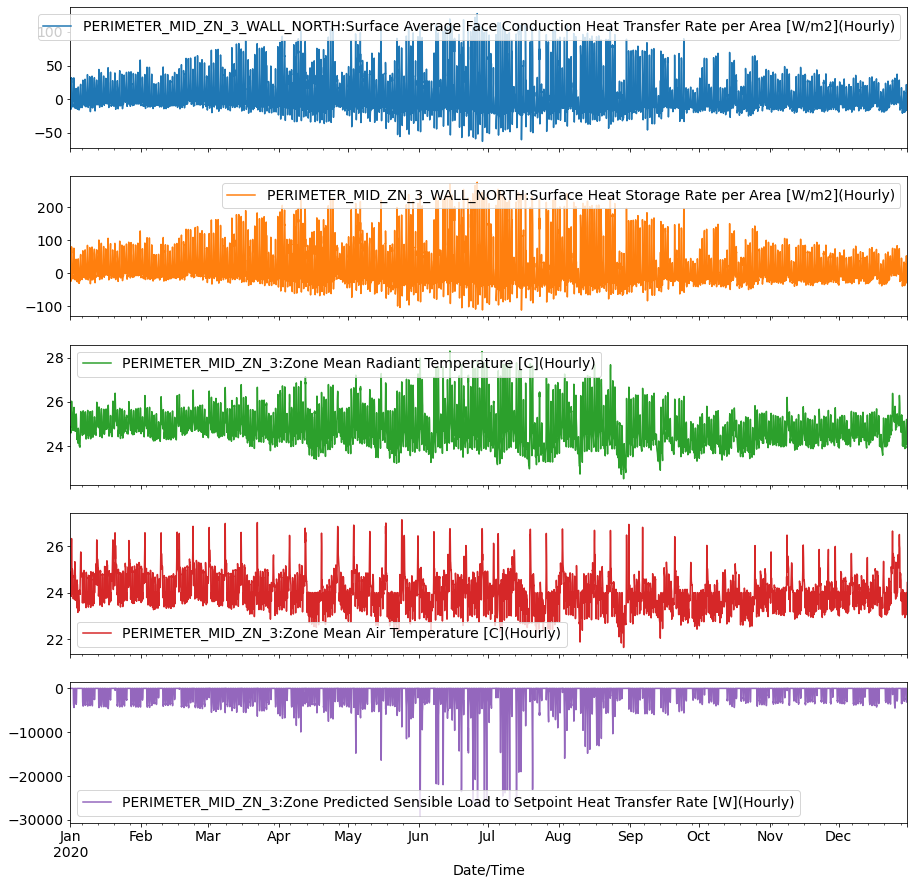

In [96]:
ZN_3_iso2020.plot(figsize=(15,15), subplots=True)

array([<AxesSubplot:xlabel='Date/Time'>, <AxesSubplot:xlabel='Date/Time'>,
       <AxesSubplot:xlabel='Date/Time'>, <AxesSubplot:xlabel='Date/Time'>,
       <AxesSubplot:xlabel='Date/Time'>], dtype=object)

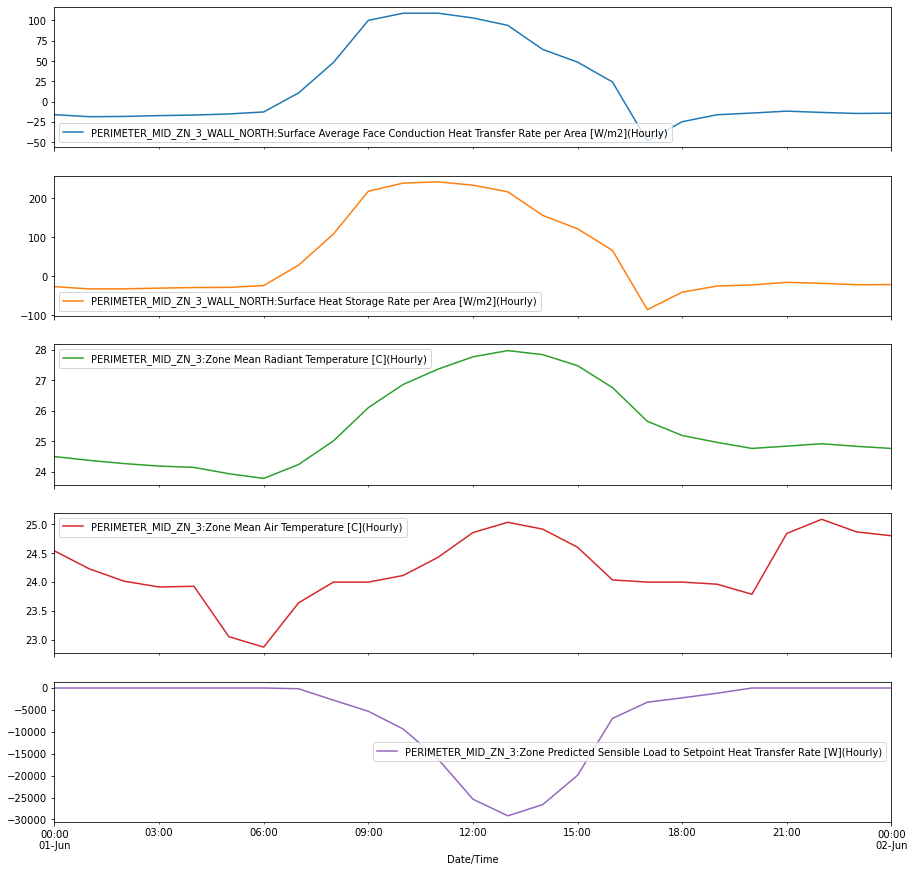

In [15]:
ZN_3_pcm2020.truncate(before='2020-06-01', 
        after='2020-06-02').plot(figsize=(15,15), subplots=True)

<AxesSubplot:xlabel='Date/Time'>

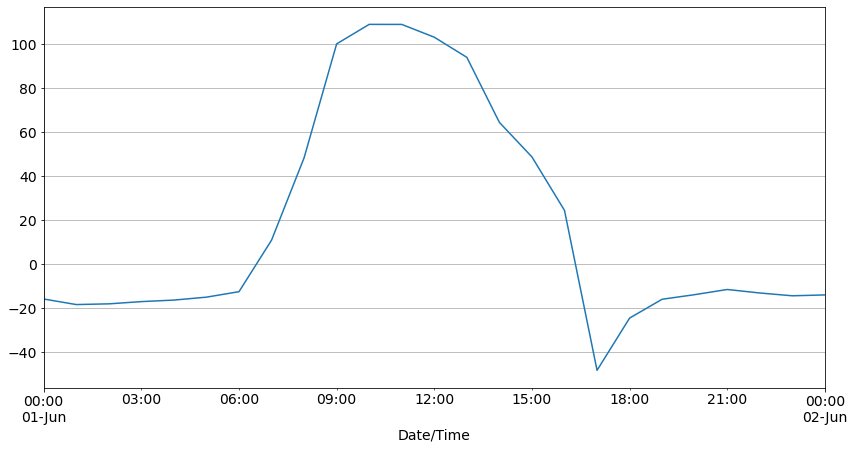

In [73]:
df_ZN_3['PERIMETER_MID_ZN_3_WALL_NORTH:Surface Average Face Conduction Heat Transfer Rate per Area [W/m2](Hourly)'].truncate(before='2020-06-01', 
        after='2020-06-02').plot(figsize = (14,7), grid=True)


In [ ]:
df_ZN_3['PERIMETER_MID_ZN_3:Zone Predicted Sensible Load to Setpoint Heat Transfer Rate [W](Hourly)'].truncate(before='2020-06-01', 
        after='2020-06-02').plot(figsize = (14,7), grid=True)

<AxesSubplot:xlabel='Date/Time'>

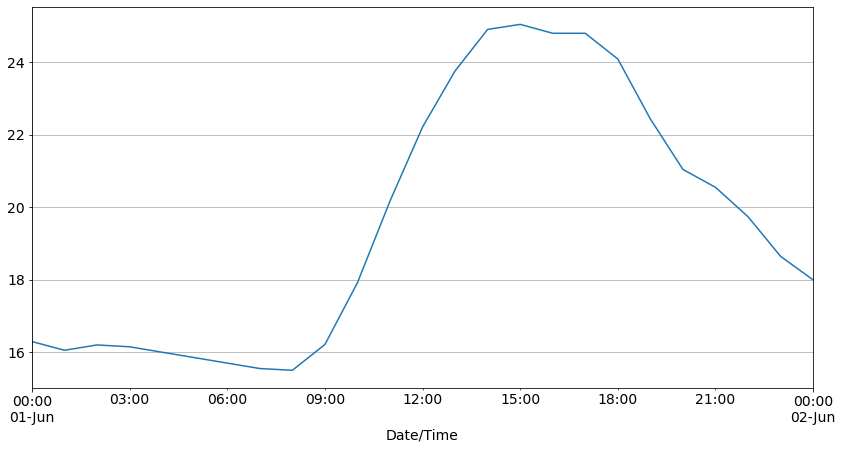

In [75]:
iso_teste.dbt.truncate(before='2020-06-01', 
        after='2020-06-02').plot(figsize = (14,7), grid=True)

### Testes epw

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

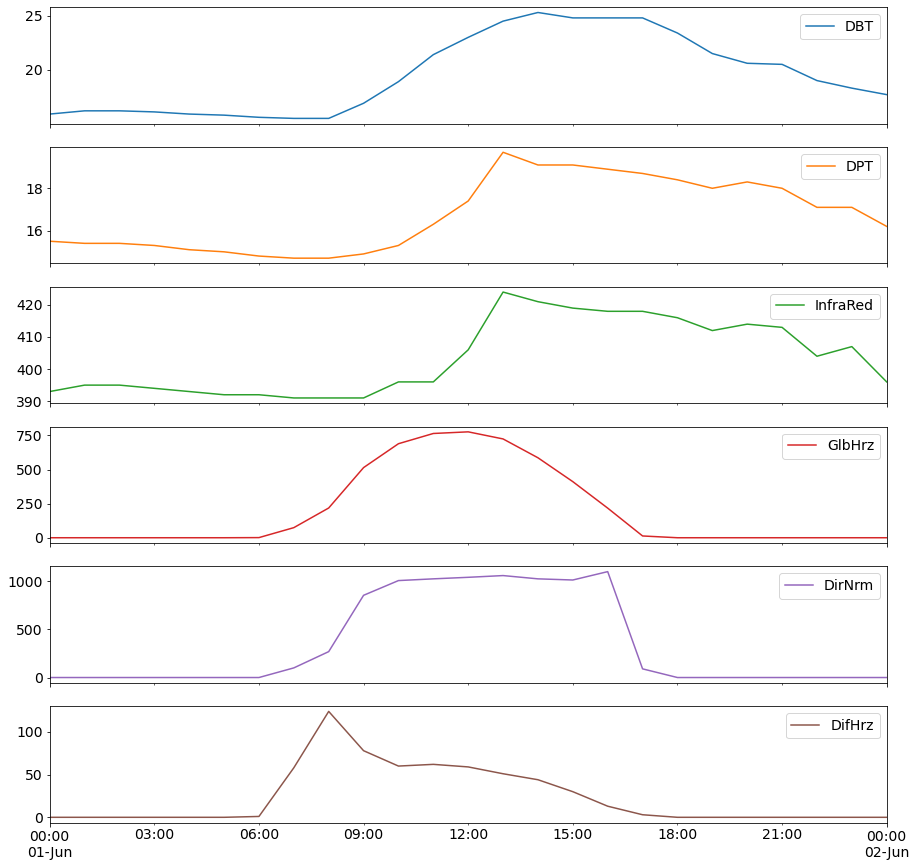

In [94]:
sp2020 = climate('BRA_Sao Paulo-Congonhas AP_HadCM3-A2-2020.csv', 2020)

sp2020.df.truncate(before='2020-06-01', after='2020-06-02').plot(figsize=(15,15), subplots=True)

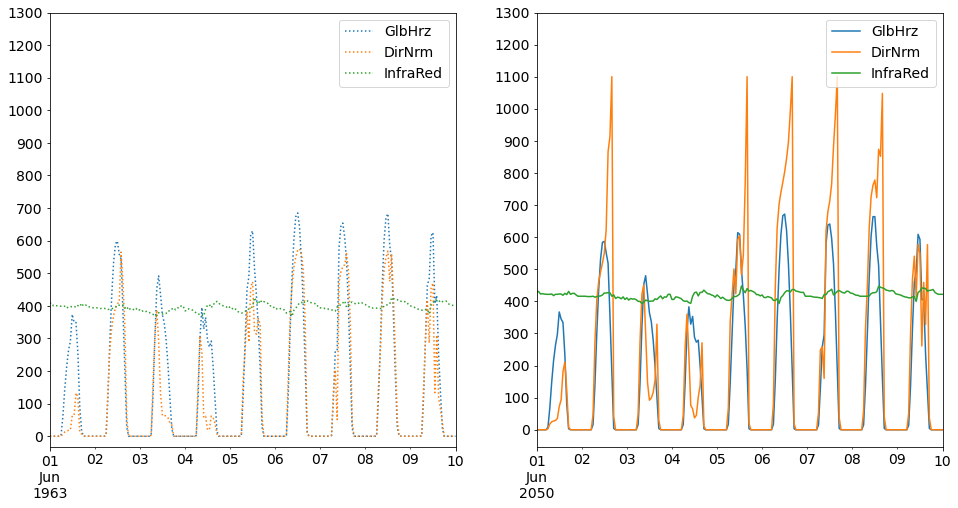

In [88]:
rj2050 = climate('climaticos/Rio-de-Janeiro-2050.csv', 2050)
rj1963 = climate('climaticos/BRA_RJ_Rio.de.Janeiro-Galeao-Jobim.Intl.AP.837460_TRY.1963.csv', 1963)

data = rj2050.df.truncate(before='2050-06-01', after='2050-06-10')
data63 = rj1963.df.truncate(before='1963-06-01', after='1963-06-10')

fig, (ax, ax2) = plt.subplots(ncols = 2)

data.plot(y = ['GlbHrz', 'DirNrm', 'InfraRed'], ax=ax2, figsize=(16,8), yticks = np.arange(0,1400,100))
data63.plot(y = ['GlbHrz', 'DirNrm', 'InfraRed'], ax=ax, ls=':', figsize=(16,8), yticks = np.arange(0,1400,100))

plt.show()

<AxesSubplot:>

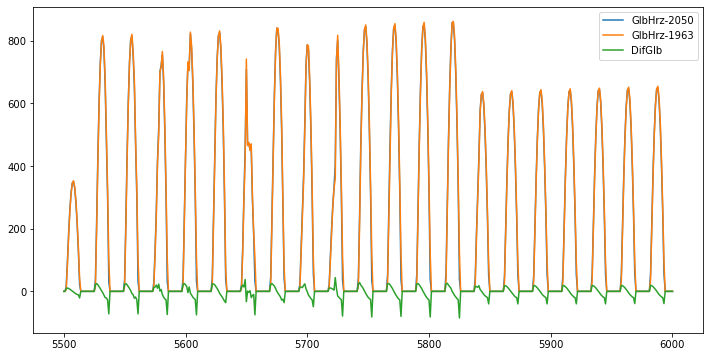

In [ ]:
compar = pd.DataFrame()

compar.index = range(len(rj2050))
compar['GlbHrz-2050'] = rj2050['GlbHrz'].values
compar['GlbHrz-1963'] = rj1963['GlbHrz'].values
compar['DifGlb'] = compar['GlbHrz-2050'] - compar['GlbHrz-1963']

compar.truncate(before=5500, after=6000).plot(y=['GlbHrz-2050', 'GlbHrz-1963', 'DifGlb'], figsize=(12,6))